# Stage 0 Load 3 Datasets

In [1]:
import pandas as pd 
df_train = pd.read_csv('../Data/df_18800_train.csv')
df_syn = pd.read_csv('../Data/df_18800_train_TabDDPM_defaultTransformer_300_1_0.csv')
df_holdout = pd.read_csv('../Data/df_18800_holdout.csv')
df_val = pd.read_csv('../Data/df_18800_val.csv')
print("data is loaded...") # 0.3 s

data is loaded...


In [2]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate(df_train)
uf.calculate_label_rate(df_syn)
uf.calculate_label_rate(df_holdout)
uf.calculate_label_rate(df_val)

Total Sample size is 5367, Positive Sample size is 159, Negative Sample size is 5208, label rate is 0.03
Total Sample size is 5367, Positive Sample size is 207, Negative Sample size is 5160, label rate is 0.04
Total Sample size is 5367, Positive Sample size is 159, Negative Sample size is 5208, label rate is 0.03
Total Sample size is 2684, Positive Sample size is 80, Negative Sample size is 2604, label rate is 0.03


# Stage 1 Train Classifier

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 假設你的目標變量列名叫 'label'
X = df_train.drop('label', axis=1)  # 特徵數據
y = df_train['label']  # 目標數據

# 創建Logistic Regression模型
model = LogisticRegression()

# 訓練模型
model.fit(X, y)

/Users/murasaki526/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [4]:
# 加載驗證數據
X_val = df_val.drop('label', axis=1)  # 特徵數據
y_val = df_val['label']  # 目標數據

# 在驗證數據集上預測
val_predictions = model.predict(X_val)

# 計算驗證集的準確度
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

Validation Accuracy: 0.97


# Stage 2 More refined performance metric

In [5]:
import matplotlib.pyplot as plt

# 在驗證數據集上進行預測
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)[:, 1]

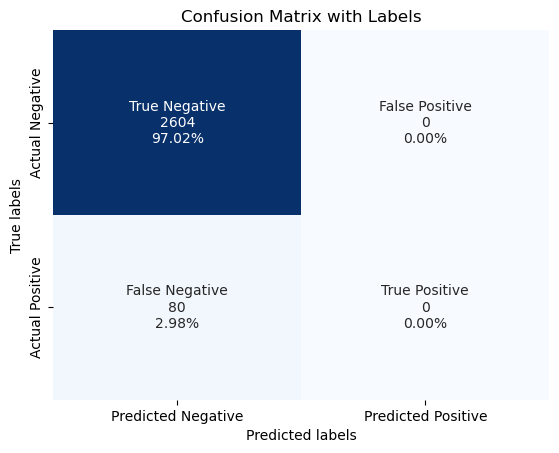

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 計算混淆矩陣
cm = confusion_matrix(y_val, y_pred)
cm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
cm_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
cm_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_labels, cm_counts, cm_percentages)]

labels = np.asarray(labels).reshape(2,2)

# 繪製帶標籤的混淆矩陣
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix with Labels')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

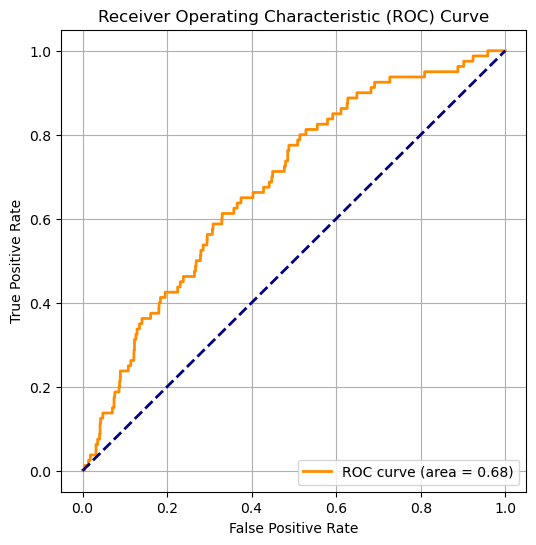

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)